In [2]:
import yaml
import tqdm
import sys
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from keras import backend as K
from collections import OrderedDict
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from ptype.reliability import compute_calibration, reliability_diagram, reliability_diagrams
from ptype.plotting import plot_confusion_matrix, conus_plot
from ptype.callbacks import get_callbacks, MetricsCallback
from ptype.models import DenseNeuralNetwork
from ptype.data import load_ptype_data_day, preprocess_data

from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram

In [4]:
config = "../config/p-type.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [5]:
texas = conf["case_studies"]["texas"]
new_york = conf["case_studies"]["new_york"]
ne_noreaster = conf["case_studies"]["ne_noreaster"]
dec_ice_storm = conf["case_studies"]["dec_ice_storm"]
test_days = texas + new_york + ne_noreaster + dec_ice_storm

In [6]:
input_features = conf['TEMP_C'] + conf['T_DEWPOINT_C'] + conf['UGRD_m/s'] + conf['VGRD_m/s']
output_features = conf['ptypes']

In [7]:
data = load_ptype_data_day(
    conf, 
    data_split = 0, 
    verbose = 1
) 

In [8]:
scaled_data, scalers = preprocess_data(
    data, 
    input_features, 
    output_features, 
    scaler_type="standard", 
    encoder_type="onehot"
)

In [9]:
try:
    del mlp
    K.clear_session()
    gc.collect()
except:
    pass

In [10]:
callbacks = [MetricsCallback(scaled_data["val_x"], scaled_data["val_y"], name = "val")]
callbacks += get_callbacks(conf)

In [11]:
mlp = DenseNeuralNetwork(
    **conf["model"],
    callbacks=callbacks
)

In [12]:
history = mlp.fit(scaled_data["train_x"], scaled_data["train_y"])

2022-10-10 13:21:47.287142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 13:21:47.790385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


1415/1415 [==============================] - 1s 964us/step


In [13]:
preds = mlp.predict(scaled_data["test_x"])

23/23 [==============================] - 0s 2ms/step


In [14]:
true_labels = np.argmax(scaled_data["test_y"], 1)
pred_labels = np.argmax(preds, 1)
confidences = np.take_along_axis(
    preds,
    pred_labels[:, None], 
    axis=1
)

data["test"]["true_label"] = true_labels
data["test"]["pred_label"] = pred_labels
data["test"]["pred_conf"] = confidences
data["test"]["accuracy"] = (data["test"]["pred_label"] == data["test"]["true_label"]).to_numpy()

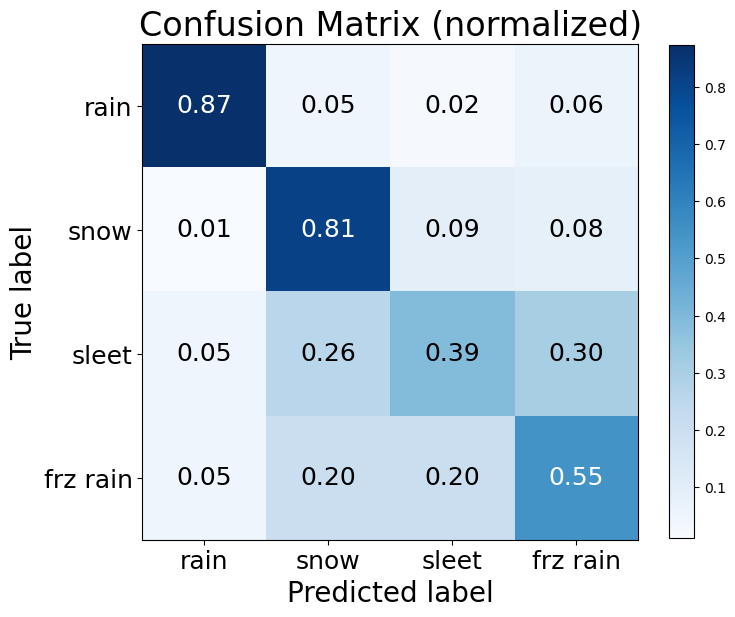

In [15]:
plot_confusion_matrix(data["test"]["true_label"], 
                      data["test"]["pred_label"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      normalize=True,
                      title=f'Confusion Matrix (normalized)')#, filename='cm_norm.png')

plt.show()

In [16]:
rocs = []
for i in range(4):
    forecasts = data["test"]['pred_conf']
    obs = np.where(data["test"]['true_label'] == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.01, 0.01),
                         obs_threshold=0.5)
    roc.update(forecasts, obs)
    rocs.append(roc)

roc_curve(rocs,
          ["rain", "snow", "sleet", "frz rain"], 
          ["blue", "grey", "red", "purple"], 
          ["s", "o", "v", "^"],
          os.path.join(conf["save_loc"], "roc_curve.png"))
    
performance_diagram(rocs, 
                    ["rain", "snow", "sleet", "frz rain"], 
                    ["blue", "grey", "red", "purple"], 
                    ["s", "o", "v", "^"],
                    os.path.join(conf["save_loc"], "performance.png"))

/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:133: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [17]:
results_calibration = compute_calibration(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10)

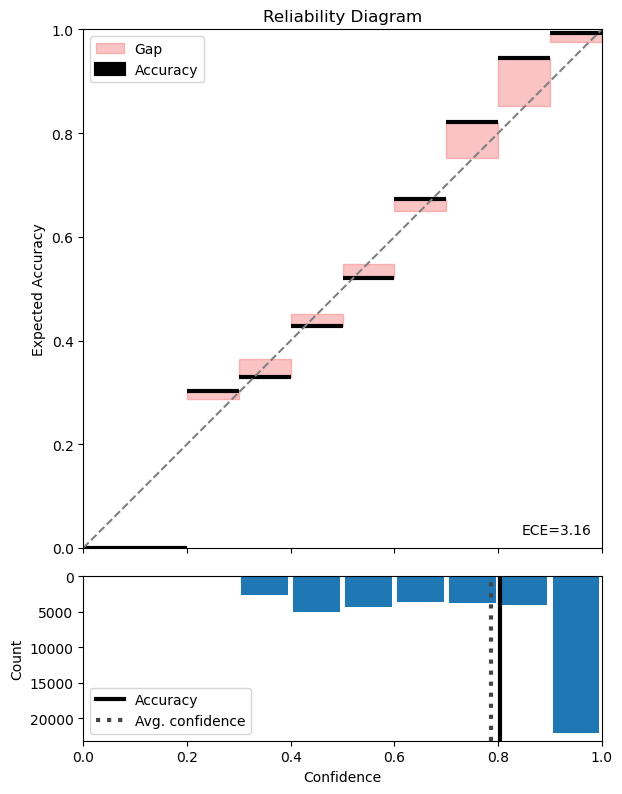

In [18]:
reliability_diagram(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10, dpi=100)

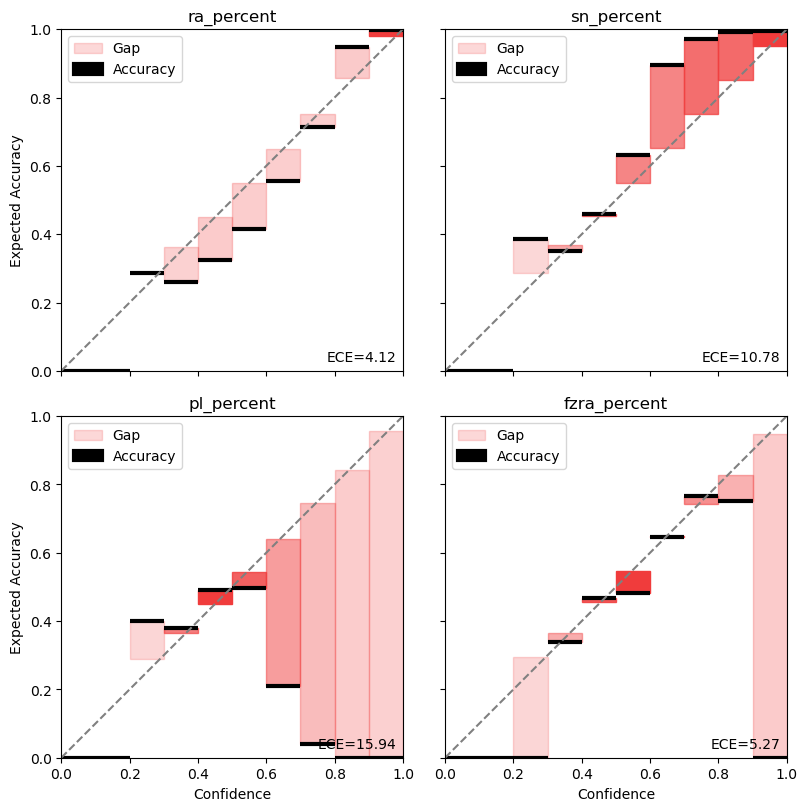

In [19]:
results = OrderedDict()
for label in range(scaled_data["test_y"].shape[-1]):
    cond = (data["test"]["true_label"] == label)
    results[output_features[label]] = {
        "true_labels": data["test"][cond]["true_label"].values, 
        "pred_labels": data["test"][cond]["pred_label"].values, 
        "confidences": data["test"][cond]["pred_conf"].values
    }
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [20]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

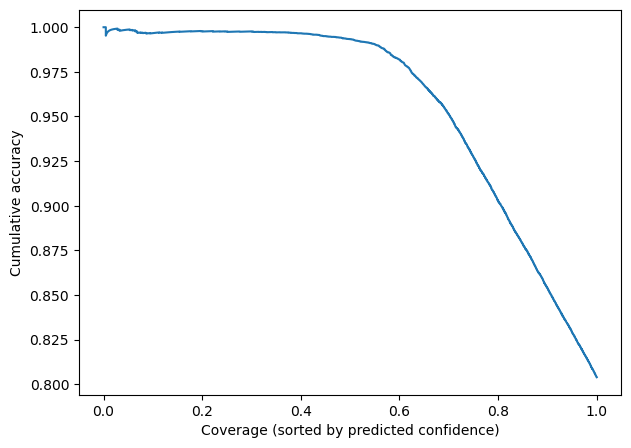

In [21]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
_test_data_sorted = compute_cov(data["test"], col = "pred_conf", quan = "accuracy")
ax.plot(
    _test_data_sorted["pred_conf_cov"],
    _test_data_sorted["cu_accuracy"]
)
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.show()

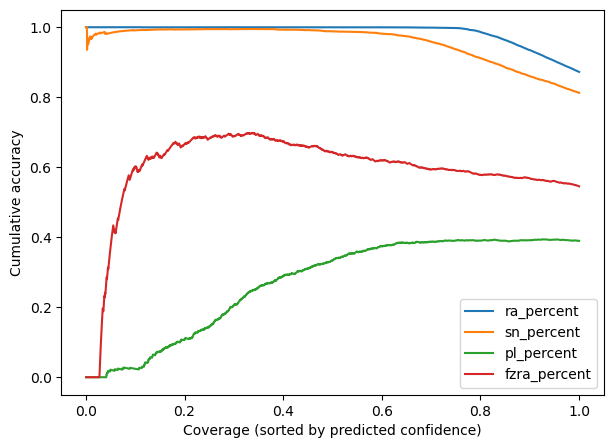

In [22]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
for label in range(data["test"].shape[-1]):
    cond = (data["test"]["true_label"] == label)
    _test_data_sorted = compute_cov(data["test"][cond], col = "pred_conf", quan = "accuracy")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_accuracy"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.legend(output_features)
plt.show()

/glade/work/schreck/py37/lib/python3.7/site-packages/ptype/plotting.py:173: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


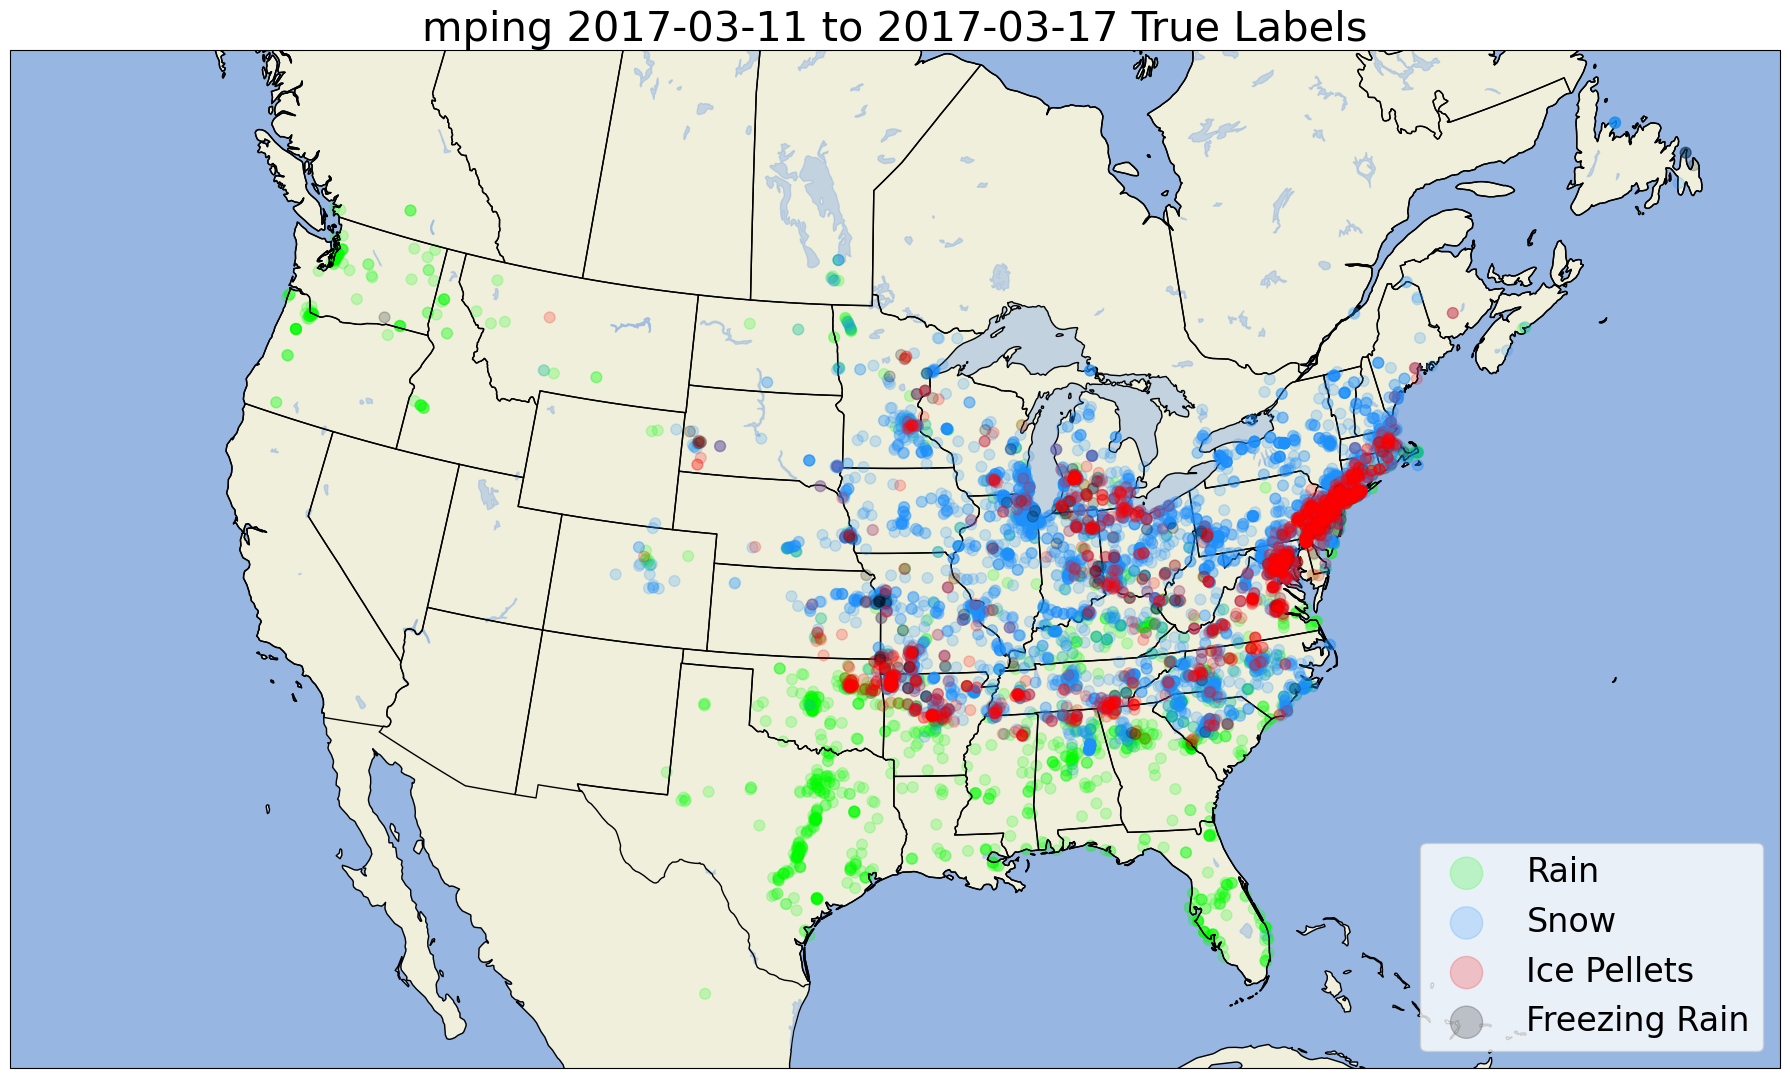

/glade/work/schreck/py37/lib/python3.7/site-packages/ptype/plotting.py:173: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


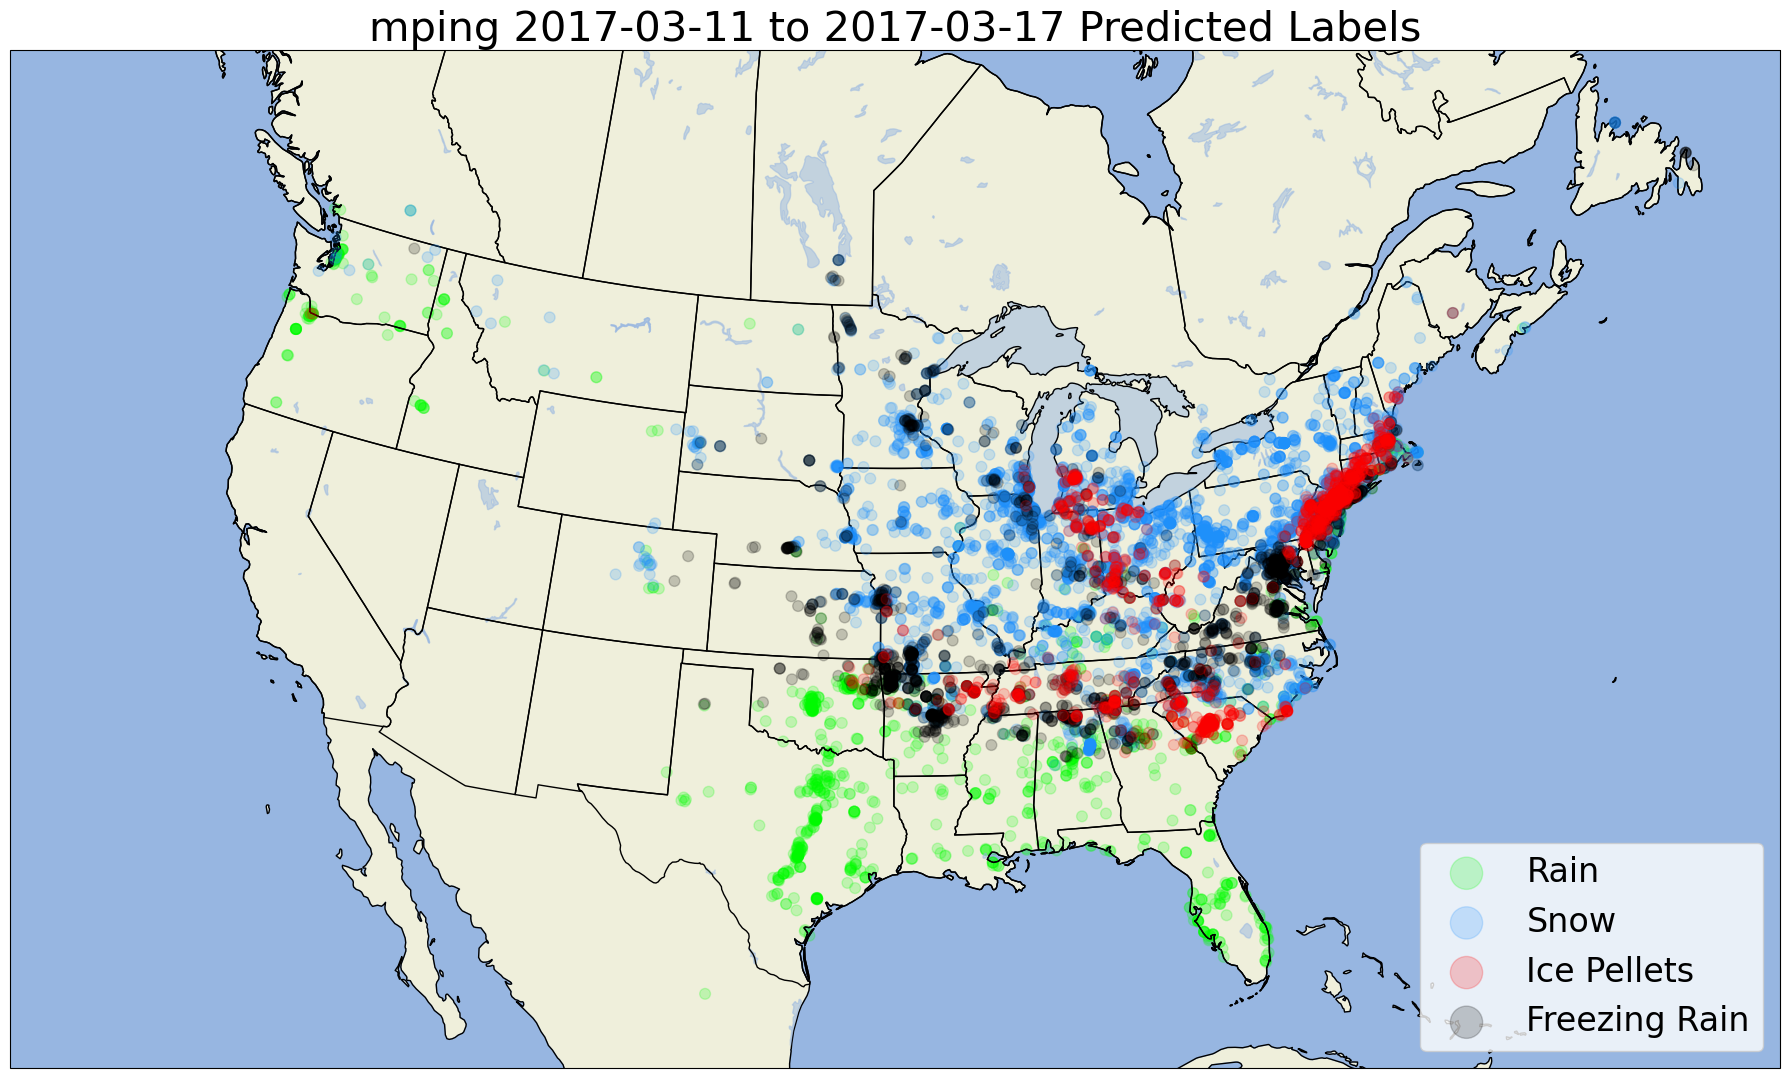

In [23]:
conus_plot(
    data["test"][data["test"]["day"].isin(ne_noreaster)], 
    column = 'true_label', 
    title = "True"
)

conus_plot(
    data["test"][data["test"]["day"].isin(ne_noreaster)], 
    column = 'pred_label',
    title = "Predicted"
)

/glade/work/schreck/py37/lib/python3.7/site-packages/ptype/plotting.py:173: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


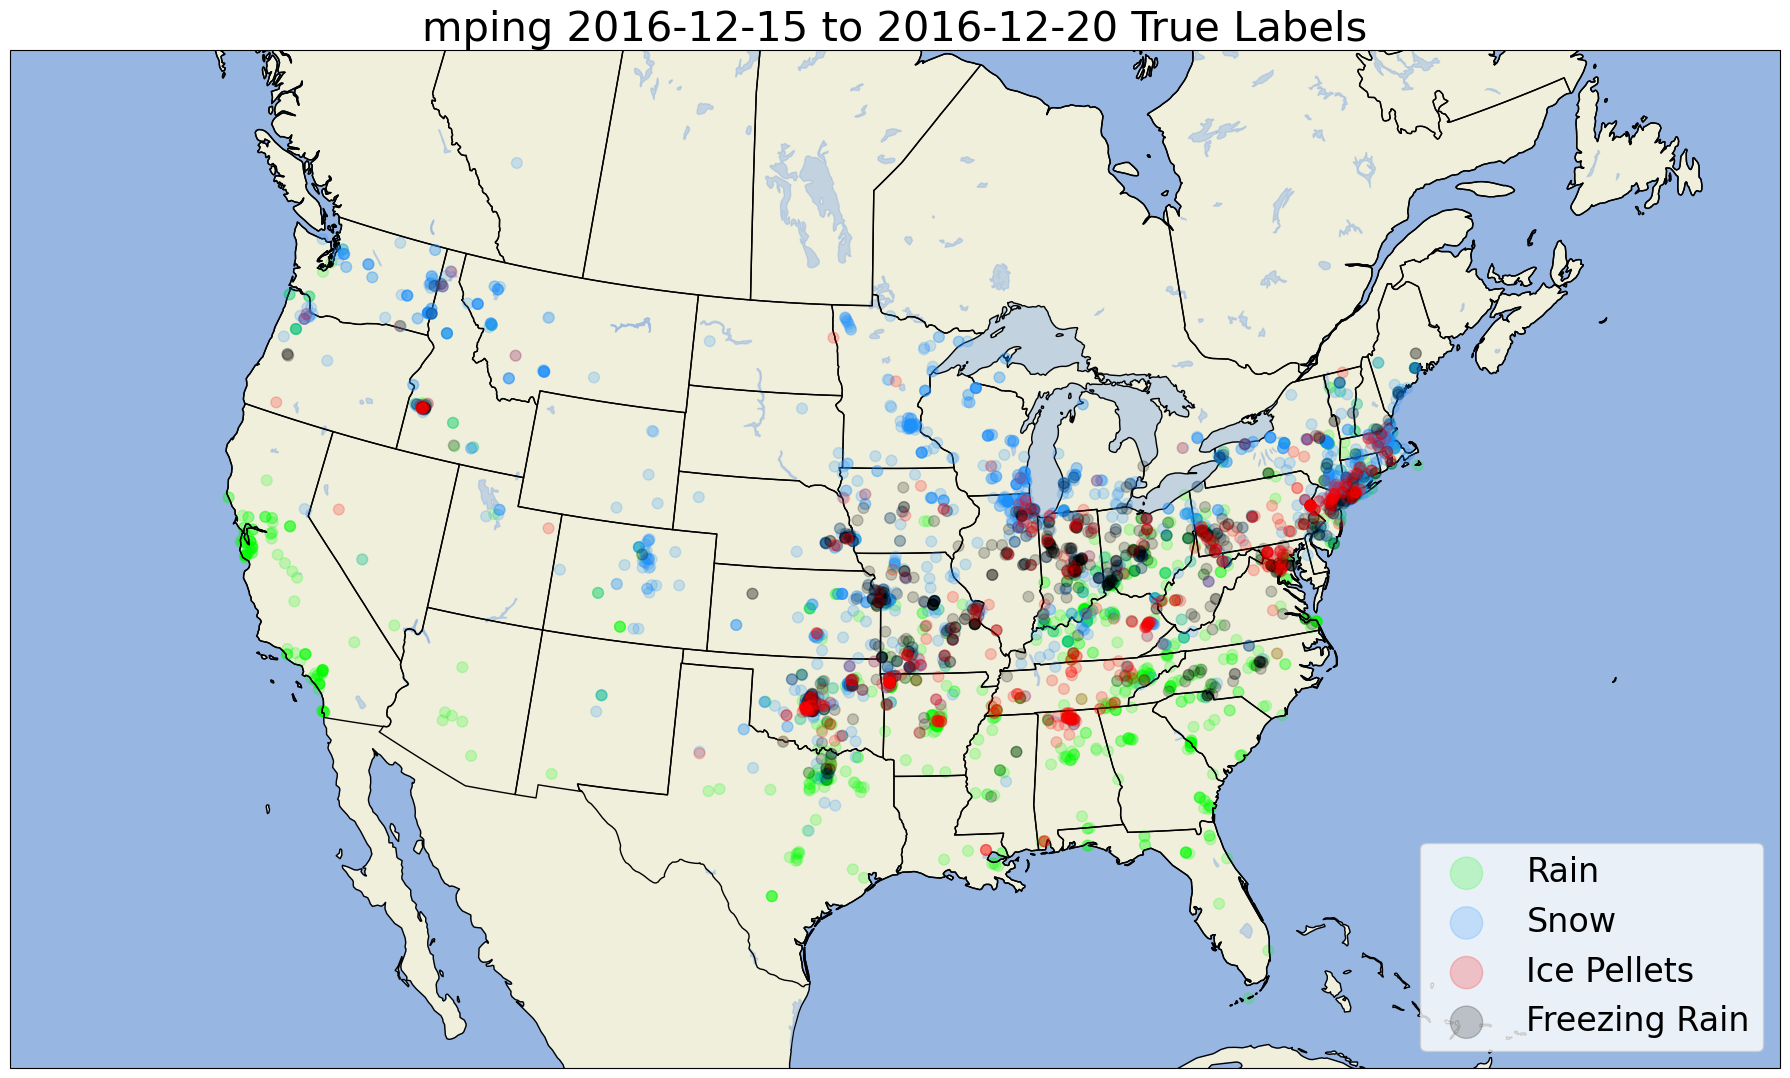

/glade/work/schreck/py37/lib/python3.7/site-packages/ptype/plotting.py:173: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


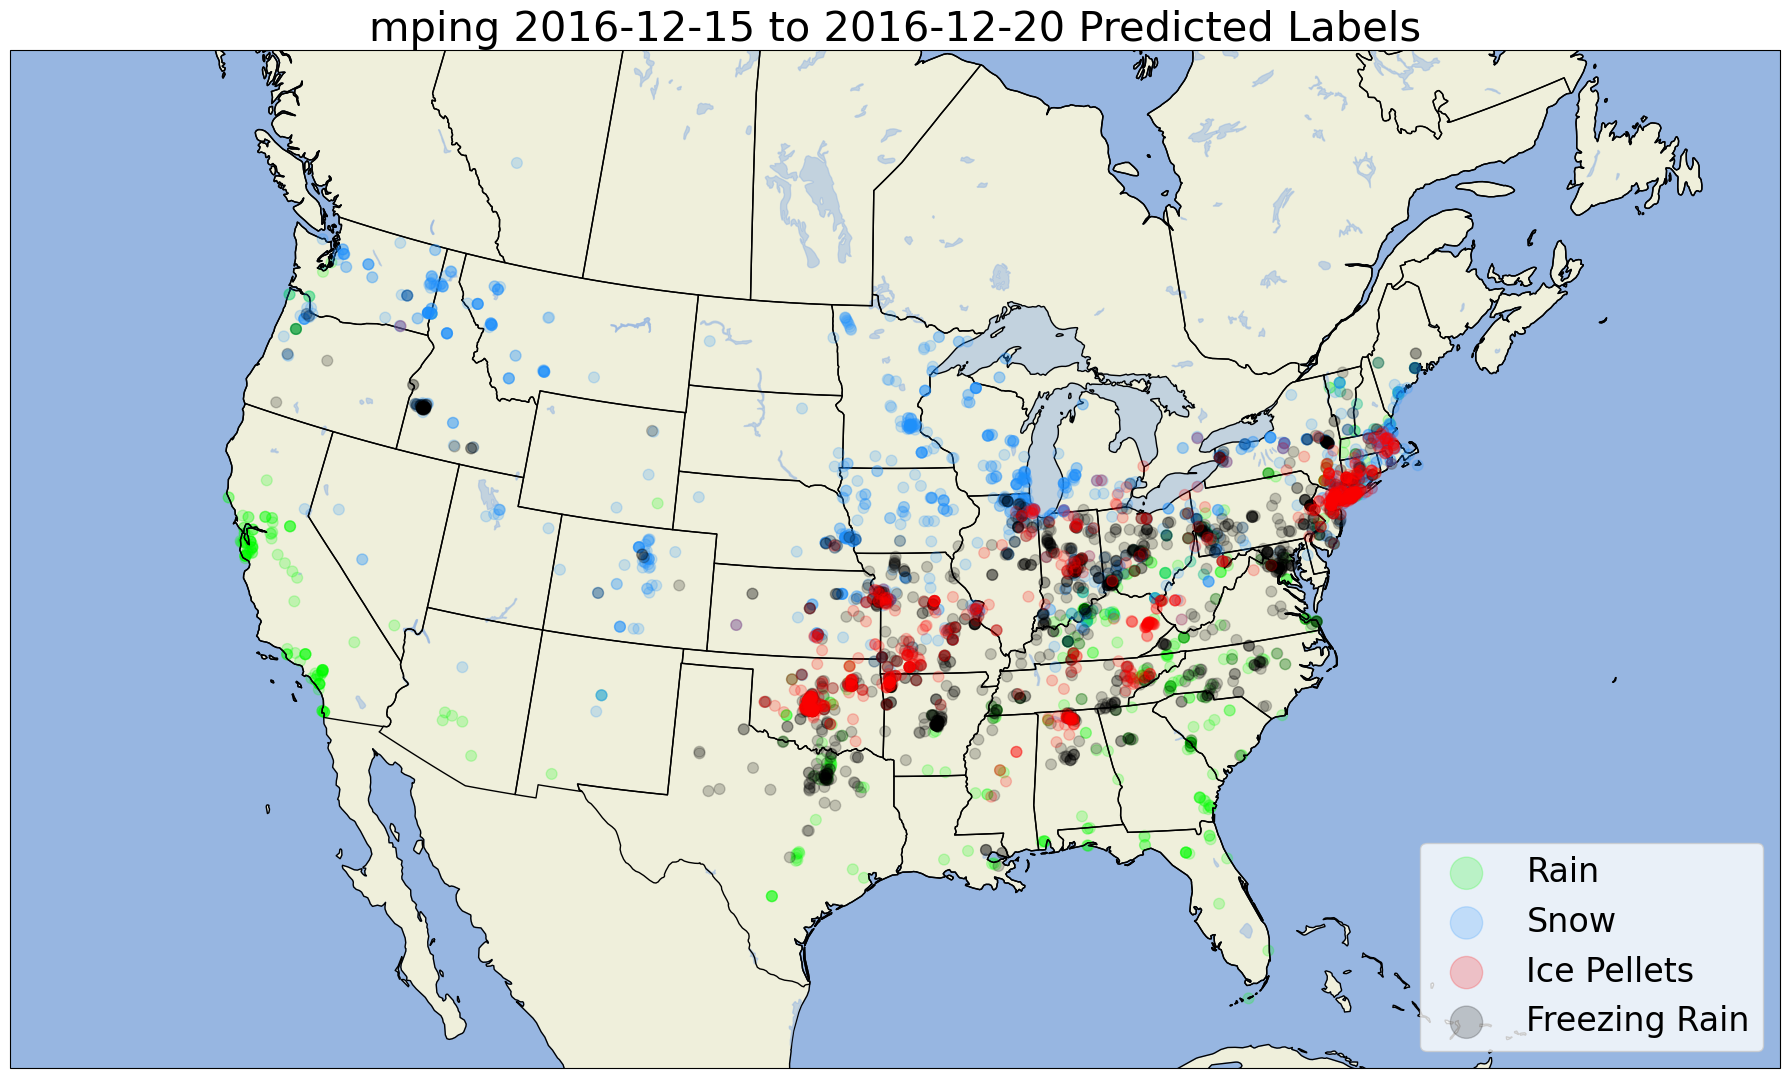

In [24]:
conus_plot(
    data["test"][data["test"]["day"].isin(dec_ice_storm)], 
    column = 'true_label', 
    title = "True"
)

conus_plot(
    data["test"][data["test"]["day"].isin(dec_ice_storm)], 
    column = 'pred_label', 
    title = "Predicted"
)